# Twitter Sentiment Analysis with Geo Location

General climate change sentiment of tweets in english, searching for the terms:

- climate change
- global warming

Excluding:

- replies
- retweets

Timeframe: 2019-2021

Tweets: 11041

**Importing libraries**

In [1]:
#Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text Processing
#nltk.download('punkt')
#nltk.download('wordnet')
import spacy
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from emoji import UNICODE_EMOJI

**Importing data**

In [2]:
df = pd.read_csv('../Data/tweets_geo.csv', index_col=0)

In [3]:
df = df.reset_index().reindex(df.columns, axis=1)

In [4]:
#Creating new columns for year and month
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [5]:
df['year'].value_counts() #drop 2010 to 2018?

2019    3808
2021    3774
2020    3459
2014     634
2015     274
2013     186
2017     152
2012     122
2016      90
2018      86
2011      16
2010       4
Name: year, dtype: int64

In [6]:
df=df[df['year'].isin(['2019', '2020', '2021'])]

In [7]:
len(df)

11041

In [8]:
df['year'].value_counts()

2019    3808
2021    3774
2020    3459
Name: year, dtype: int64

In [9]:
df['content'][1]

'In @UNECOSOC OAS, @AOSISChair highlights "#SIDS response cannot &amp; should not be solely left and be concentrated through only the Multi-Country Office." Cites multidimensional challenges to SIDs including #debt, #climatechange &amp; #inequalities.'

**Cleaning text**

In [10]:
def tweet_preprocessing(tweet):
    
    '''
    This functions cleans tweets from line breaks, URLs, numbers, etc.
    '''
    
    tweet = tweet.lower() #to lower case
    tweet = tweet.replace('\n', ' ') # remove line breaks
    tweet = tweet.replace('\@(\w*)', '') # remove mentions
    tweet = re.sub(r"\bhttps://t.co/\w+", '', tweet) # remove URLs
    tweet = re.sub('\w*\d\w*', '', tweet) # remove numbers
    tweet = re.sub(r'\#', '', tweet) # remove hashtags. To remove full hashtag: '\#(\w*)'
    tweet = re.sub('\w*\d\w*', '', tweet) # removes numbers?
    tweet = re.sub(' +', ' ', tweet) # remove 1+ spaces

    return tweet

In [11]:
def strip_emoji(text):
    
    '''
    This function removes any emojis
    '''
    
    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return RE_EMOJI.sub(r'', text)

In [12]:
#applying functions to clean tweets
df['content_clean'] = df['content'].apply(tweet_preprocessing)
df['content_clean'] = df['content_clean'].apply(strip_emoji)

In [13]:
#Tokanizing tweets
tt = TweetTokenizer()
df['content_clean'] = df['content_clean'].apply(tt.tokenize)

In [14]:
#Cleaning tokens
df['content_clean'] = df['content_clean'].apply(lambda x: " ".join(x for x in x if re.match(r'[^\W\d]*$', x)))

In [15]:
# Lemmatizing

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df['content_clean'] = df['content_clean'].apply(lemmatize_text)

In [16]:
df['content_clean'][10]

['african',
 'rainforest',
 'slow',
 'climate',
 'change',
 'despite',
 'record',
 'heat',
 'thomson',
 'reuters',
 'more',
 'w',
 'ecosearch']

In [17]:
#Removing stop words
stop = stopwords.words('english')
df['content_clean'] = df['content_clean'].apply(lambda x: " ".join(x for x in x if x not in stop))

In [18]:
df['content_clean'][10]

'african rainforest slow climate change despite record heat thomson reuters w ecosearch'

In [19]:
#Removing words that are negative but not negative in the climate setting
to_remove = ['fight', 'fighting', 'crisis', 'threat', 'threaten']

df['content_clean'] = df['content_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in to_remove))

In [20]:
#Final cleaned tweet
df['content_clean'][10]

'african rainforest slow climate change despite record heat thomson reuters w ecosearch'

**Predicting Sentiment**

In [21]:
#sentiment with vader
analyzer = SentimentIntensityAnalyzer()

scores = []
compound_list = []
positive_list = []
negative_list = []
neutral_list = []

for i in range(df['content_clean'].shape[0]):
    compound = analyzer.polarity_scores(df['content_clean'][i])["compound"]
    pos = analyzer.polarity_scores(df['content_clean'][i])["pos"]
    neu = analyzer.polarity_scores(df['content_clean'][i])["neu"]
    neg = analyzer.polarity_scores(df['content_clean'][i])["neg"]
    
    scores.append({"comp": compound,
                       "positive": pos,
                       "negative": neg,
                       "neutral": neu
                  })
    
sentiments_score = pd.DataFrame.from_dict(scores)
df = df.join(sentiments_score)

In [22]:
df.head(3)

,id,user,date,content,user_location,user_city,year,month,content_clean,comp,positive,negative,neutral
0,1394673778492379144,"{'username': 'InsidePhilanthr', 'displayname':...",2021-05-18 15:18:35+00:00,After years of its community being upended by ...,"Los Angeles, CA",Los Angeles,2021,5,year community upended extreme weather greater...,0.4173,0.117,0.000,0.883
1,1394673502834335750,"{'username': 'gpolicywatch', 'displayname': 'G...",2021-05-18 15:17:29+00:00,"In @UNECOSOC OAS, @AOSISChair highlights ""#SID...","New York, USA",New York,2021,5,oas highlight sids response cannot solely left...,0.0516,0.183,0.124,0.693
2,1394673249200459780,"{'username': 'Davelai11', 'displayname': 'Dave...",2021-05-18 15:16:29+00:00,Will God be awarded a Rolex to save us for coo...,"Los Angeles, CA",Los Angeles,2021,5,god awarded rolex save u cooling u global warming,0.8225,0.658,0.000,0.342


<AxesSubplot:xlabel='positive'>

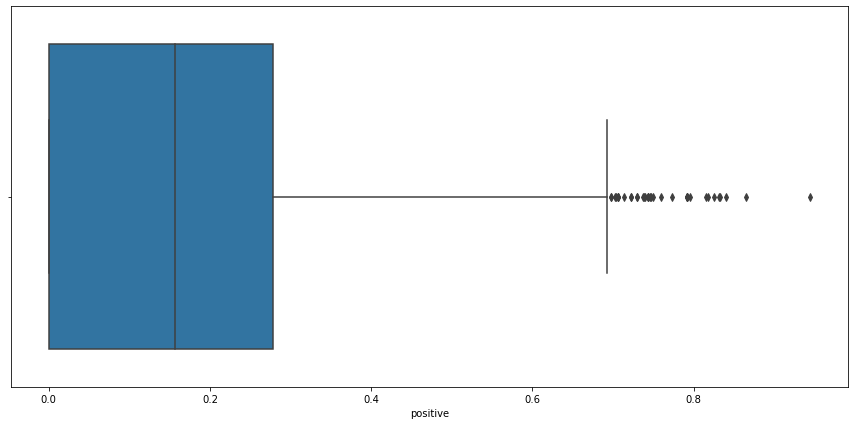

In [23]:
#distribution of polarity
plt.figure(figsize=(15, 7))
sns.boxplot(x = df['positive'])

<AxesSubplot:xlabel='negative'>

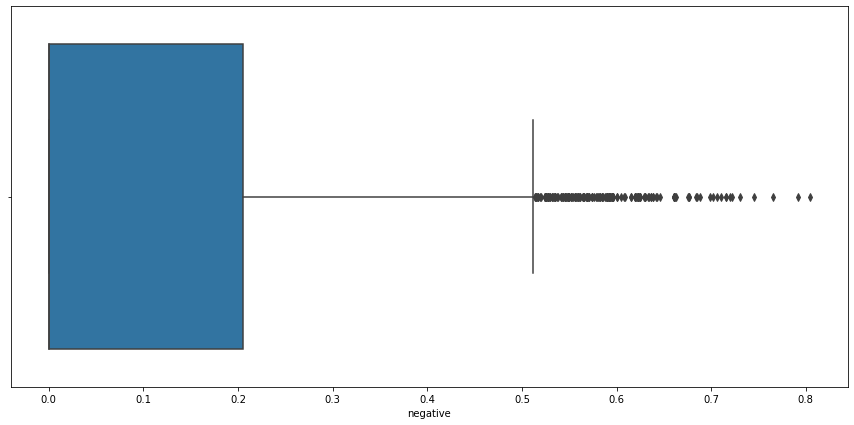

In [24]:
plt.figure(figsize=(15, 7))
sns.boxplot(x = df['negative'])

In [25]:
#Creating column with sentiment description
df['sentiment'] = np.where(df['comp'] > 0.1, 'positive', (np.where(df['comp'] < -0.1, 'negative', 'neutral')))

In [26]:
#Getting number of values in each category
sentiment_dist = df['sentiment'].value_counts().to_frame().reset_index().rename(columns={'index': 'sentiment', 'sentiment': 'count'})
sentiment_dist

,sentiment,count
0,positive,5236
1,negative,3295
2,neutral,2510


<AxesSubplot:xlabel='sentiment', ylabel='count'>

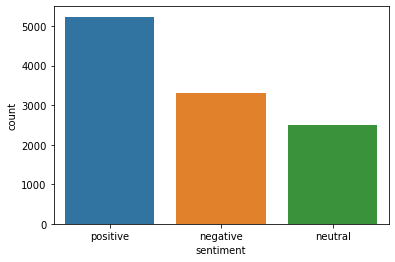

In [27]:
sns.barplot(x=sentiment_dist['sentiment'], y=sentiment_dist['count'])

In [33]:
df[df['sentiment'] == 'neutral'].head(10)

,id,user,date,content,user_location,user_city,year,month,content_clean,comp,positive,negative,neutral,sentiment
1,1394673502834335750,"{'username': 'gpolicywatch', 'displayname': 'G...",2021-05-18 15:17:29+00:00,"In @UNECOSOC OAS, @AOSISChair highlights ""#SID...","New York, USA",New York,2021,5,oas highlight sids response cannot solely left...,0.0516,0.183,0.124,0.693,neutral
10,1394670445794889735,"{'username': 'ecobearwitness', 'displayname': ...",2021-05-18 15:05:20+00:00,African rainforests slow climate change despit...,"New York, USA",New York,2021,5,african rainforest slow climate change despite...,0.0000,0.000,0.000,1.000,neutral
28,1394659614143262724,"{'username': 'ConsciousFash', 'displayname': '...",2021-05-18 14:22:18+00:00,Our 🌍 &amp; inhabitants are under increasing p...,"New York, NY",New York,2021,5,inhabitant increasing pressure climatechange s...,-0.0516,0.182,0.193,0.625,neutral
30,1394658734203449348,"{'username': 'MarketWatch', 'displayname': 'Ma...",2021-05-18 14:18:48+00:00,Scientists: Antarctica is headed for a climate...,"New York, NY",New York,2021,5,scientist antarctica headed tipping point,0.0000,0.000,0.000,1.000,neutral
31,1394657123837960197,"{'username': 'etopianewsnow', 'displayname': '...",2021-05-18 14:12:24+00:00,https://t.co/9KJ5Xpl0wj. #GPT3 opines on #Eter...,Los Angeles,Los Angeles,2021,5,opines eternalvalues face technologicaldevelop...,0.0000,0.000,0.000,1.000,neutral
34,1394656447372353537,"{'username': 'jswatz', 'displayname': 'John Sc...",2021-05-18 14:09:43+00:00,That the country’s two most populous states we...,"New York, NY",New York,2021,5,country two populous state laid low suggests p...,-0.0516,0.073,0.081,0.846,neutral
38,1394654827972595713,"{'username': 'ecobearwitness', 'displayname': ...",2021-05-18 14:03:17+00:00,California's Giant Redwoods Could Hold Key to ...,"New York, USA",New York,2021,5,giant redwood could hold key climate change cb...,0.0000,0.000,0.000,1.000,neutral
42,1394654106355175429,"{'username': 'DesignApplause', 'displayname': ...",2021-05-18 14:00:25+00:00,Getting to Net Zero – Immediate Climate Action...,chicago,Chicago,2021,5,getting net zero immediate climate action indu...,0.0000,0.000,0.000,1.000,neutral
44,1394653293285105667,"{'username': 'economics', 'displayname': 'Bloo...",2021-05-18 13:57:11+00:00,Ours is a global society accustomed to eternal...,"New York, NY",New York,2021,5,global society accustomed eternal debate margi...,0.0000,0.000,0.000,1.000,neutral
50,1394649616583249924,"{'username': 'Jake_1791', 'displayname': 'Jake...",2021-05-18 13:42:34+00:00,African rainforests still slowed climate chang...,"Philadelphia, PA, USA",Philadelphia,2021,5,african rainforest still slowed climate change...,0.0000,0.000,0.000,1.000,neutral


In [29]:
#getting positve hashtags
HT_positive = []

def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags
# extracting hashtags from positive tweetsHT_positive = hashtag_extract(df_tws['text'][df_tws['sent'] == 1])
# extracting hashtags from  tweets
HT_positive = hashtag_extract(df['content'][df['comp'] > 0.5])
# unnesting list
HT_positive = sum(HT_positive,[])
HT_positive

['TuesdayMorning',
 'ClimateChange',
 'ClimateChange',
 'SciComm',
 'SouthernTier',
 'ClimateTech',
 'Startups',
 'ClimateChange',
 'ClimateChange',
 'ClimateAction',
 'climatechange',
 'ClimateChange',
 'TechForGoodSpotlight',
 'TechForGood',
 'climatechange',
 'climatemitigation',
 'TX',
 'ERCOT',
 'ClimateChange',
 'TXLege',
 'innovative',
 'airpollution',
 'sustainable',
 'manufacturingindustry',
 'EU',
 'research',
 'horizon2020',
 'climatechange',
 'carbonfootprint',
 'tworainsconference',
 'climatechange',
 'archaeology',
 'bioarchaeology',
 'IndusCivilization',
 'tworainsconference',
 'climatechange',
 'archaeology',
 'tworains',
 'tworainsconference',
 'climate',
 'climatechange',
 'archaeology',
 'COVID19',
 'construction',
 'climatechange',
 'CLIMATE',
 'GlobalWarming',
 'climatechange',
 'POLLUTIONs',
 'GlobalWarming',
 'climatechange',
 'machinelearning',
 'AI',
 'financialservices',
 'climate',
 'insurance',
 'climatechange',
 'climatetech',
 'climatechange',
 'greentech'

In [30]:
#Saving data
df.to_csv('../Data/sentiments_geo.csv')